In [1]:
import bliss.datasets.galsim_galaxies as galaxies
import os

In [2]:
os.chdir("../..")

In [96]:
g = galaxies.SDSSGalaxies({"bands": [2]}, slen=53)

In [97]:
g

In [98]:
im = g[0]

In [99]:
im.shape

AttributeError: 'dict' object has no attribute 'shape'

In [100]:
im['images'].shape

torch.Size([1, 53, 53])

In [101]:
from matplotlib import pyplot as plt

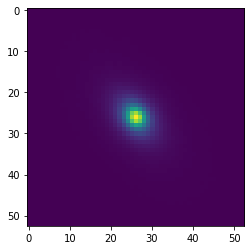

In [102]:
plt.imshow(im['images'][0])

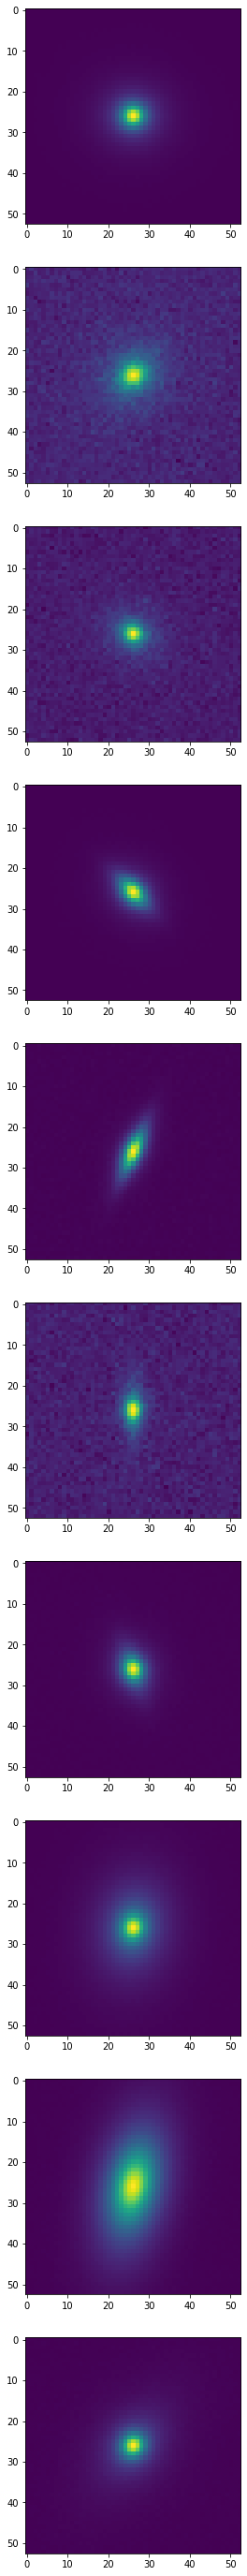

In [103]:
fig, axes = plt.subplots(10, figsize=(5, 50))
for ax in axes:
    ax.imshow(g[2]["images"][0])

In [104]:
import torch
import pytorch_lightning as pl
import numpy as np
import torch.nn.functional as F
from torch import nn

In [105]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch, *args, bn=True, relu=True, **kwargs):
        seq_args = [nn.Conv2d(in_ch, out_ch, *args, **kwargs)]
        if bn:
            seq_args += [nn.BatchNorm2d(out_ch)]
        if relu:
            seq_args += [nn.ReLU()]
        super().__init__(*seq_args)
        
class ConvTBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch, *args, bn=True, relu=True, **kwargs):
        seq_args = [nn.ConvTranspose2d(in_ch, out_ch,  *args, **kwargs)]
        if bn:
            seq_args += [nn.BatchNorm2d(out_ch)]
        if relu:
            seq_args += [nn.ReLU()]
        super().__init__(*seq_args)


class GalaxyAutoencoder(pl.LightningModule):
    def __init__(self, slen=64, start_channels=1, n_layers=None):
        super().__init__()
        #self.n_layers = int(np.log2(slen))
        if not n_layers:
            n_layers = int(np.log2(slen))
        self.n_layers=n_layers
        
        down_layers = []
        up_layers = []
        
        self.bn1 = nn.BatchNorm2d(1)
        
        for i in range(self.n_layers):
            down_layers.append(ConvBlock(
                start_channels * (2**i), 
                start_channels * (2**(i+1)),
                (3,3),
                2,
                1,
                #bn=(i<(self.n_layers-1)),
                #relu=(i<(self.n_layers-1)),
            ))
            up_layers.append(ConvTBlock(
                start_channels * (2**(i+1)),
                start_channels * (2**i), 
                (3,3),
                2,
                1,
                bn=(i>0),
                relu=(i>0),
                output_padding=1
            ))
        down_layers.append(nn.Conv2d(start_channels * (2**(n_layers)), start_channels * (2**(n_layers)), (1,1), 1))
        self.encoder = nn.Sequential(*down_layers)
        self.decoder = nn.Sequential(*up_layers[::-1])
        
        self.loss = nn.MSELoss()
        
    def forward(self, X):
        Z = self.encoder(self.bn1(X))
        #print(Z.shape)
        X_prime = self.decoder(Z)
        #print(X_prime.shape)
        return X_prime
    
    def training_step(self, batch, batch_idx):
        X = batch["images"]
        X_prime = self.forward(X)
        return self.loss(X, X_prime)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer       

In [106]:
from bliss.models.galaxy_net import OneCenteredGalaxyAE

In [107]:
train_loader = g.train_dataloader()
train_loader

In [108]:
trainer = pl.Trainer(gpus=[6], max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [115]:
model = OneCenteredGalaxyAE(slen=53, optimizer_params={"name":"Adam", "kwargs": {"lr": 1e-3}})

In [116]:
trainer.fit(model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                  | Params
-----------------------------------------------
0 | enc  | CenteredGalaxyEncoder | 54.4 K
1 | dec  | CenteredGalaxyDecoder | 54.6 K
-----------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.436     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dereklh/.cache/pypoetry/virtualenvs/bliss-FSmgvuKM-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dereklh/.cache/pypoetry/virtualenvs/bliss-FSmgvuKM-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

In [141]:
pred = model(g[2]["images"], g[2]["background"].unsqueeze(0))[0, 0]

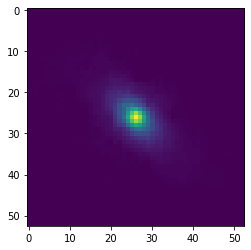

In [142]:
plt.imshow(pred.detach())

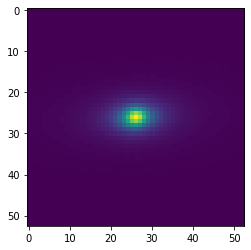

In [143]:
plt.imshow(g[2]["images"][0])

In [22]:
train_loader

In [23]:
train_loader[0]

TypeError: 'DataLoader' object is not subscriptable

In [87]:
model

GalaxyAutoencoder(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): ConvBlock(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvBlock(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvBlock(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): ConvBlock(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Sequential(
    (0): ConvTBlock(
      (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), outp